
# PGAM Tutorial

## Introduction
This tutorial is aimed to introduce the user to some key concepts of Generalized Additive Model (GAMs), how these concepts are implemented in this specific PGAM library, and describe in detail how to estimate tuning functions with the PGAM library on an example syntetic dataset.


## Why GAMs?
<!--
Estimating tuning functions entails finding maps that characterize how a set of task variables affects the firing rate of a recorded neuron. Some of the challenges that comes with this estimation problem are: (i) the experimenter has no direct access to the firing rate, but can only measure spikes; (ii) there may be no a priori hypothesis on the shape of the tuning functions (excluding some well characterized special case, e.g. the Gabor filter-like responses in V1); (iii) correlations between task variables may be a confunding factor (e.g. if eye movemet and hand movement are correlated during a reaching movement, it becomes hard to discriminate if the hand, the eye or a combination of both is driving a neuron).  

During naturalistic experiments, where there is a lack of identical trial repeats and the behavior is less constrained, those challenges become even more prominent: (i) the firing rate cannot be easily estimated by trial averaging over "identical" experimental conditions; (ii) cortical neurons manifest a strong mixed selectivity to a multitude of behavioral covariates and stimuli features that may not be apparent in trial-based experiments due to the simpler, usually multi-alternative stimulus and response space. Mixed selective reponses are not yet fully characterized for most brain areas; (iii) finally, no/weaker control over the animal behavior and sensory experience may introduce additional correlations (e.g. a correlation between eye position and visual stimuli will arise if no eye-fixation is imposed).
-->

Generalized Linear Models (GLMs) have been succesful in characterizing mixed selective responses by capturing well the statistics of spike trains (which can be modelled as Poisson distributed observations, no averaging needed) and by jointly estimating the contribution of a (potentially) large number of task variables. 

However, GLMs comes with their own limitations. In particular, one needs to carefully choose how to represent tuning functions (in the case of GLMs this translates into chosing an appropriate basis of functions, e.g. Gaussian-shaped, Fourrier, cosine raised... and the number of basis element to be used). More importantly, defining the minimal subset of variable which drive the neural activity becomes cumbersome for a naive implementations. Variables are usually selected through model comparison, an approach that becomes quickly unfeasible when the number of task variable increases (combinatorial explosion of candidate models). Additionally, classical stepwise methods comes with well known theoretical and practical flaws (e.g., Frank Harrell (2001)).

Our solution takles those limitation by taking advantage of GAM theory. GAMs are non-linear extensions of GLMs that retain the advantages mentioned above (model counts directly and jointly infers responses), but additoinally learns from the data the type of non-linearities that are suited to represent each individual response function. As we will see in the tutorial, this will translate into learning the proper prior distribution over a set of possible response functions. The appproach comes with the additional benefit of deriving confidence intervals over the model parameters that can be used to select the minimal subset of variables driving neural acticity. Since selection is based on statistical testing, we completely circumvented costly model comparison. 

Overall, our approach is both user-friendly, requiring less choices for the user, and computatoinally advantageous when variable selection is required.



## What is covered in the tutorial?

The tutorial will cover the main components of the model, in particular:

1. <a href="#repr-nl">**Representing non-linearities**: </a>

    1.1 <a href="#b-spline">**B-spline definition and properties**</a> To familiarize ourselves with the concept of B-splines, we will plot b-splines for different type of response functions: 1D and 2D responses, cyclic or not, and temporal kernels.
    
    1.2 <a href="#sm-prior">**Smoothing prior**</a> We will introduce the concept of smoothing prior and clarify the role of the smoothing prior in GAM fitting. We will provide intuitive insight into the role of the prior by drawing and plottnig functions sampled from different levels of smoothing. 


2. <a href="#pgam-lib">**Introduction to the PGAM library**</a> We will illustrate how the concepts introduced in the tutorial are implemented in the PGAM library and applied to the problem of tuning function estimation.

    2.1 <a href="#sm-handl">**Define the B-spline via the *smooths_handler* class**</a>: We will use a particular class (smooths_handler) to appropriately format the model covariates, as well as design the B-spline and the corresponding smoothing pealization.

    2.2. <a href="#model-fit">**Model fit**</a>: Fit the model by jointly learning the smoothing levels and the B-spline parametters.
    
    2.3. <a href="#post-proc">**Post processing**</a>: Post-process model outputs, plot and explore the outputs.

In [1]:
# Import libraries

import sys
## if working outside the docker container, uncomment the line below and add the path to [YOUR PATH TO PGAM FOLDER]/src/
## sys.path.append('[YOUR PATH TO PGAM FOLDER]/src/')
sys.path.append('src/')

import numpy as np
import sys
from PGAM.GAM_library import *
import PGAM.gam_data_handlers as gdh
import matplotlib.pylab as plt
import pandas as pd
from post_processing import postprocess_results
from scipy.io import savemat

<!-- We want a section here, just saying that you are going to show them b-splines for fun, because it's important -->




# 1. Representing non-linearities <a name="repr-nl">

An approach to build a tuning function is to describe this tuning function by a weighted sum of simple basis elements. For example, visual responses to gratings are classicaly described by a basis of Gaussian tuning functions. In our case we will use B-splines because of their flexibility in describing arbitrarily shaped response functions with few components. Creating an appropriate set of basis is important and can go wrong. In this section we will build B-splines for illustrative purposes.

## 1.1 B-spline definition and properties <a name="b-spline">
B-splines are a basis set of piecewise polynomials. This basis is defined recursively, see (https://en.wikipedia.org/wiki/B-spline) over a set of knots where the polynomial pieces meet. Given this recursive nature, in order to fully cover the the domain of interest (e.g., x-axis of the eventual tuning function), one needs to add additional knots outside or at the edge of the domain.  The most common choice is to simply repeat the first and last knot $n-1$ times, where n is the degree of the polynomial used. The total number of knots and the degree of the polynomial determine the number of basis elements. 


<!-- split this block of text (and code) so they correspond 1 to 1 -->

Knots number: 15
B-spline dimension: 11


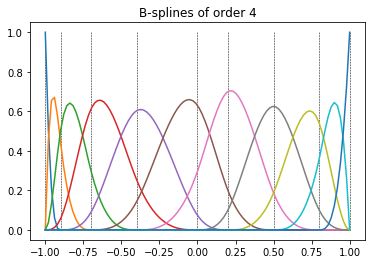

In [2]:
# Cubic B-spline covering [-1,1]

# Input (100 equispaced samples in which the B-spline will be evaluated)
x = np.linspace(-1, 1, 100)
order = 4 # the order of the spline is the number of coefficient of the polynomials (1-degree of the poly)

# specify some internal knots
int_knots = np.array([-1., -.9, -0.7, -.4, 0, .2, .5, .8, 1.0])

# Repeat external knots. These are repeated order-1 times. Thus, in this example, with 9 internal knots and order 4
# you will end up with 15 knots (3+9+3).
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))
print('Knots number: %d'%len(knots))

# Evaluate the spline basis at x. X is of shape (samples x betas/basis functions)
# in this example, we have 100 samples and the number of betas is defined by number of knots - order 
# Thus, x should be 100 x 11
X = gdh.splineDesign(knots, x, order, der=0)

print('B-spline dimension: %d'%X.shape[1])

plt.figure()
plt.title('B-splines of order %d'%(order))
for spline_i in range(X.shape[1]):
    plt.plot(x,X[:,spline_i])
plt.vlines(int_knots, 0,1,ls ='--', color='k',lw=0.5)


### Representing circular variables: cyclic B-spline

Cyclical B-spline can be defined to describe responses to cyclical input variables (angles); since there are no borders for cyclic variables, the specification of the internal knots fully characterizes the cyclical B-spline.

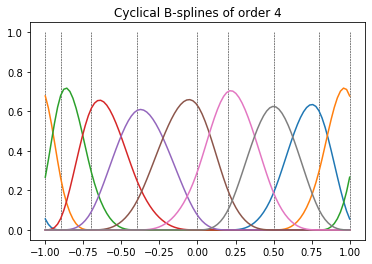

In [4]:
# get the cyclical b-spline over the same domain 
# (for cyclic spline basis, knots repetition is not required)
cX = gdh.cSplineDes(int_knots, x, order, der=0)

# plot the cyclical basis
plt.figure()
plt.title('Cyclical B-splines of order %d'%(order))
for spline_i in range(cX.shape[1]):
    plt.plot(x,cX[:,spline_i])
plt.vlines(int_knots, 0,1,ls ='--', color='k',lw=0.5)

### B-spline coverage

If the domain is correcty specified, the sum of the B-splines over internal points should equal to one.


In [5]:
# Assert that the B-spline convers the input range
assert(all(np.abs(X.sum(axis=1) - 1) < 10**-12))
assert(all(np.abs(cX.sum(axis=1) - 1) < 10**-12))
print('Sum over the basis functions of a regular B-spline: ', X.sum(axis=1)[:10])
print('Sum over the basis functions of a cyclical B-spline: ', X.sum(axis=1)[:10])


Sum over the basis functions of a regular B-spline:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Sum over the basis functions of a cyclical B-spline:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### B-spline of different order
Below some example of B-splines of different order over the same knots.

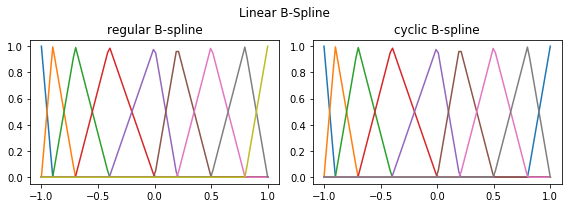

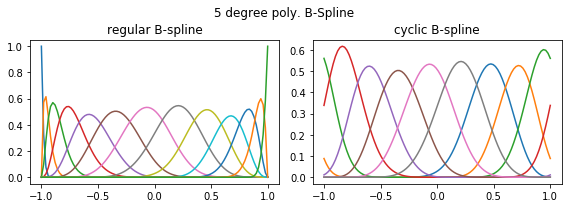

In [6]:
## Linear B-spline
order = 2
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))

# get the spline basis evaluated at x for the domain
X = gdh.splineDesign(knots, x, order, der=0)

# get the cyclical b-spline over the same domain 
# (for cyclic spline basis, knots repetition is not required)
cX = gdh.cSplineDes(int_knots, x, order, der=0)

# plot the basis
plt.figure(figsize=(8,3))
plt.suptitle('Linear B-Spline')

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

x_rep = np.repeat(x, X.shape[1]).reshape(x.shape[0],-1)
p1 = ax1.plot(x_rep,X)
ax1.set_title('regular B-spline')

x_rep = np.repeat(x, cX.shape[1]).reshape(x.shape[0],-1)
ax2.set_title('cyclic B-spline')
p2 = ax2.plot(x_rep,cX)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


## 5-degree B-spline
order = 6
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))

# get the spline basis evaluated at x for the domain
X = gdh.splineDesign(knots, x, order, der=0, outer_ok=True)

# get the cyclical b-spline over the same domain 
# (for cyclic spline basis, knots repetition is not required)
cX = gdh.cSplineDes(int_knots, x, order, der=0)

# plot the basis
plt.figure(figsize=(8,3))
plt.suptitle('5 degree poly. B-Spline')

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

x_rep = np.repeat(x, X.shape[1]).reshape(x.shape[0],-1)
p1 = ax1.plot(x_rep,X)
ax1.set_title('regular B-spline')

x_rep = np.repeat(x, cX.shape[1]).reshape(x.shape[0],-1)
ax2.set_title('cyclic B-spline')
p2 = ax2.plot(x_rep,cX)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Higer dimensional B-spline

It is possible to define a basis for multidimensinal response functions as a tensor product of uni-dimensional basis. For example, a 2D response function could be expanded as $f(x,y) \approx \sum_{ij} \alpha_i \beta_j a_i(x)b_j(y)$, where $\{a_1, \dots, a_n\}$  and $\{b_1, \dots, b_m\}$ are B-splines over the domain of $x$ and $y$ respectively.

<IPython.core.display.Javascript object>


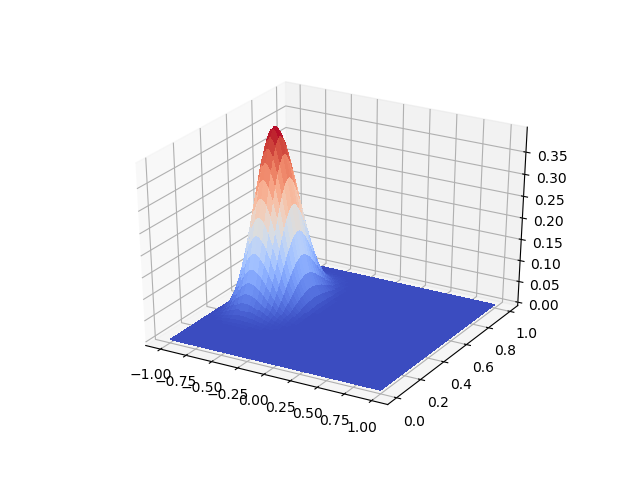

In [7]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
# 2D basis set for product of cubic interpolaties
order = 4
int_knots_x = np.linspace(-1,1,8)
int_knots_y = np.linspace(0,1,6)
knots_x = np.hstack(([int_knots_x[0]]*(order-1), int_knots_x, [int_knots_x[-1]]*(order-1)))
knots_y = np.hstack(([int_knots_y[0]]*(order-1), int_knots_y, [int_knots_y[-1]]*(order-1)))



# input variables
x = np.linspace(-1,1,100)
y = np.linspace(0,1,100)
x_mesh, y_mesh = np.meshgrid(x,y)
X = gdh.splineDesign(knots_x, x_mesh.flatten(), order, der=0)
Y = gdh.splineDesign(knots_y, y_mesh.flatten(), order, der=0)

# product basis
XY = multiRowWiseKron(X,Y, sparseX=False)

# plot a bais element
i = 20
bi = XY[:,i]
bi = bi.reshape(x_mesh.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x_mesh, y_mesh, bi, cmap=plt.get_cmap('coolwarm'),
                       linewidth=0, antialiased=False)


# 1.2 Smoothing prior<a name="sm-prior">

One strategy for learning an arbitrary non-linear response for a task variable is to start from a very flexible representation, such as that provided by the B-spline, and then constrain the space of possible solutions to a subset for which "smoothness" level is controlled by a single scalar parameter. 

The problem of learning an arbitrary non-linear response is then mapped onto the problem of appropriately setting the smoothing level.

## Single covariate example

For illustration purposes we can focus on the case of inferring the response to a single variable of interest $x_t\in\mathbb{R}$ as a predictor for the spike counts $y_t\in\mathbb{N}$. The GAM assumes a specific form for the likelihood of observing a specific spike count vector given our task variable: $\mathcal{L}(\theta) = \mathbb{P}(\mathbf{y} | \mathbf{x}, \mathbf{f}_\beta)$, where $\mathbf{f}_\beta$ is the non-linear response we aim to learn. 

As previously mentioned, the response is described in terms of the B-spline $\{b_1(x), ..., b_m(x)\}$, e.g., $\mathbf{f}_\beta(x) = \sum \beta_j b_j(x)$.

Without constraints on the values that $\beta$ can assume, the a-priori smoothness level of the response function depends solely on the number basis elements we assumed (and on the choice of basis itself in GLMs).

<!-- In order to fit the PGAM model we need to create a *smooth_handler* object with all the model covariates. As input to the *smooths_handler* class we can specify the type of regularization that we want to enforce over the response function.

In the context of the PGAM, this will consist in a penalization of the "energy" or "wiggliness" of the response function. For any response function of $\text{order} \ge 4$, the most common choice is penalizing the integral of the squared second derivative of the response,

\begin{equation}
    \mathcal{L}_j (\lambda) = \lambda \int_{D} f''(x)^2 dx,
\end{equation}

where $D$ is the domain of the variable $x$. 

Other options that do not require the response to be twice differentiable (as for the case of a basis of order 2 splines) are available. These type of penalties are based on appropriate differences of the coefficient of the splines that very roughly approximates the second derivative squared.

The $j$-th covariate will have an associated $\lambda_j$ that controls how much wiggliness is allowed. The larger the $\lambda_j$ the smoother the response function will be. These parameters will be learned from the data by maximizing a cross-validation objective function (the Generalized Cross Valiadtion score).

**Additional penalization terms**. Both second derivative based penalization will not penalize straight lines (second derivative =0). This means that even for extremely large $\lambda_j$ the response function would not be forced to $f=0$, but instead it will live in the space of straight lines. To avoid that, we explicitly penalized straight lines with an additional term that operates orthogonally to the wiggliness penalization.

-->

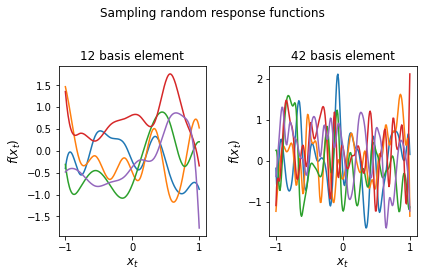

In [3]:
# here T = 200 samples of the variable x_t are created
x = np.linspace(-1, 1, 200)

# we evaluated the B-spline in some knots covering the range of x_t following the steps above
order = 4 
int_knots = np.linspace(-1,1,10)
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))
X = gdh.splineDesign(knots, x, order, der=0)

# if we assign some random coefficients to the basis we can define candidate response functions
plt.figure()
plt.suptitle('Sampling random response functions')
ax = plt.subplot(121)
ax.set_title('%d basis element'%X.shape[1])

for k in range(5):
    beta = np.random.normal(size=X.shape[1])
    plt.plot(x, np.dot(X, beta))
plt.xlabel('$x_t$', fontsize=12)
plt.ylabel('$f(x_t)$', fontsize=12)

order = 4 
int_knots = np.linspace(-1,1,40)
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))
X = gdh.splineDesign(knots, x, order, der=0)

ax = plt.subplot(122)
ax.set_title('%d basis element'%X.shape[1])
for k in range(5):
    beta = np.random.normal(size=X.shape[1])
    plt.plot(x, np.dot(X, beta))
plt.xlabel('$x_t$', fontsize=12)
plt.ylabel('$f(x_t)$', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


Given the high-flexibility of B-splines, even for a relatively low dimensional basis we may end up over-fitting the our data and estimating a very wiggly rersponse when $\beta$ are learned by maximum likelihood.

We can control the level of smoothess of the response by introducing a regulariation term to our likelihood which penalizes high energy (very wiggley) responses. The terms is simply the area under the curve of the second derivative of the rersponse function, obtaining the following:

\begin{equation}
\mathcal{L}_p = \mathcal{L} - \lambda \int \mathbf{f}_\beta^{''} (x) dx = \mathcal{L} - \lambda \beta^\top \mathbf{\text{  S}} \beta \label{eq:pen-LL} \tag{1}
\end{equation}

Here $\lambda$ is a positive scalar controlling the level of smootheness required; the higher $\lambda$ the smoother the function. In the last equation we noted that the integral can be written in terms of the B-spline coefficients.

Below we will compute the second derivative penalty matrix $\mathbf{\text{  S}}$, and we will demonstrate how the integral of the second derivative of a response function can be computed only in terms of $\beta$ and $\mathbf{\lambda \text{  S}}$.




In [4]:
from scipy.integrate import simps

# compute the penalization matrix S and the cholesky decomp. B such that S = B.T.dot(B)
samples_for_integral_approx = 10**4
# the function takes as input the knots, the range of the variable, the number of 
# samples used for approx. the integral, the order of the spline, the order of derivative, 
# 2 for second derivative and a flag for cyclic vs non-cyclic B-spline
S,B = smPenalty_1D_derBased(knots, x.min(), x.max(), samples_for_integral_approx, 
                            ord=order, der=2, cyclic=False)
S = S.toarray()
print('Check Cholesky decomposition: ', np.max(np.abs(S - B.T.dot(B))))

# set some random parameters for the response function
beta = np.random.normal(size=S.shape[0])
# We calculate the numerical integral of the square of the response function second derivative and
# show that the integral can be decribed as in equation (1)
func = lambda x : np.dot(gdh.splineDesign(knots, x, order, der=2),beta)**2

# compute numerically the integral of func and using (1)
num_integr = simps(func(np.linspace(-1,1,10**4)), x=np.linspace(-1,1,10**4))
coeff_based_integr = np.dot(np.dot(beta, S),beta)
print('Numerical integral:                 %f\nPenalization matrix based integral: %f'%(num_integr,coeff_based_integr))



Check Cholesky decomposition:  8.731149137020111e-11
Numerical integral:                 1108546.084475
Penalization matrix based integral: 1108546.084474



Equation 1 takes the form of an (improper) Gaussian  distribution with zero mean and precision  $\mathbf{\lambda \text{  S}}$ over the $\beta$. This allows us to interpret the penalization in terms of prior over candidate functions, large $\lambda$ are equivalent to sharper prior over smooth responses.

To visualize the effect of $\lambda$ over the prior, we can draw samples form it for increasingly large values of the regularizer.

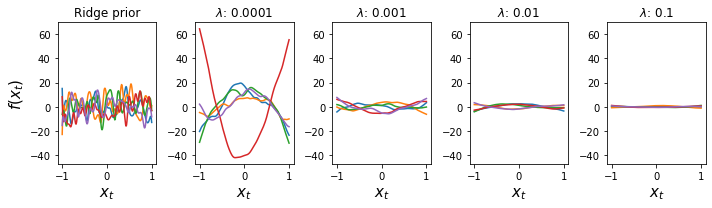

In [5]:
## define different level of regularization
lams = [0.0001,0.001,0.01,0.1]
pseudo_inv = np.linalg.pinv(S)
eig,U = np.linalg.eigh(pseudo_inv)

sqrt_pseudo_inv = U.dot(np.diag(np.abs(eig)**0.5)).dot(U.T)

# sample from different priors (gaussian)
plt.figure(figsize=(10,3))

ax = plt.subplot(1,5,1)
plt.title('Ridge prior')
for k in range(5):
    beta = np.random.normal(size=B.shape[0]) / (10*np.sqrt(lams[0]))
    plt.plot(x, np.dot(X, beta))
plt.xlabel('$x_t$',fontsize=15)
plt.ylabel('$f(x_t)$',fontsize=15)
    

for i, lam in enumerate(lams):
    plt.subplot(1,5,i+2)
    plt.title('$\lambda$: %s'%lam)
    for k in range(5):
        beta = sqrt_pseudo_inv.dot(np.random.normal(size=B.shape[0])) / np.sqrt(lam) 
        plt.plot(x, np.dot(X, beta))
    if i == 0:
        ylim = plt.ylim()
    else:
        plt.ylim(ylim)  
    plt.xlabel('$x_t$',fontsize=15)

ax.set_ylim(ylim)
plt.tight_layout()



What distinguishes GAMs from GLMs with a smoothing prior is the fact that GAMs learn an individual smoothing enforcing parameters $\lambda$ for each task variable, while in general GLMs  selects a single global regularization parameter by means of cross-validation. 

The advantage is four fold. First, GAM is more flexible in capturing differrent types of non-linearities. Second, learning a large $\lambda$ for a task variable will automatically shrinks the response function to zero (more precisely, to the null-space of the penalty matrix). Third, a single GAM fit will find the appropriate regularization, circumventing the need for cross-validating for setting the regularizer. Forth, and perhaps most imporantly from a practical standopoint, learning the appropriate degree of smoothess enables statistical testing for task-variable inclusion. Thus, there is no costly and unstable forward and backward selection procedures.

The optimization objective implemented for our particular instantiation of the GAM is known as double Generalized Cross Validation score (dGCV), and is a form of leave-one-out cross-validation. 

The dGCV is a function of the smoothing parameters $\lambda$ and can be optimized numerically with efficient algorithms. Once the $\lambda$ are found, there is a unique set of $\beta$ that maximizes likelihood of the form of (\ref{eq:pen-LL}). For more information on the learning algorithm please see [(Balzani et al, 2020)](#1). 

### Derivative based penalty vs difference based penalty <a name='der-diff-pen'>

For low order B-spline (which have null second derivative) the derivative based penalization matrix $\mathbf{\text{S}}$ must be replaced with one based on the difference between consecutive coefficient difference. The difference based penalization computes a rough estimate of the second derivative. Below we demonstrate a comparison between the derivative and the difference based penalty matrix.

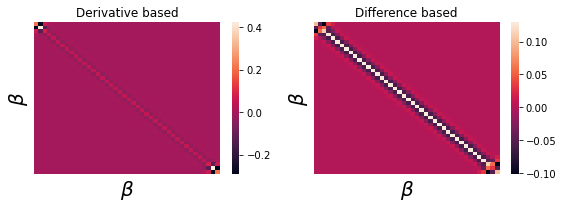

In [6]:
import seaborn as sbs
S_diff,B_diff = gdh.non_eqSpaced_diff_pen(knots, order, outer_ok=False, cyclic=False)
S_diff = S_diff.toarray()
plt.figure(figsize=(8,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.set_title('Derivative based')
ax2.set_title('Difference based')
sbs.heatmap(S/np.linalg.norm(S),ax=ax1)
sbs.heatmap(S_diff/np.linalg.norm(S_diff),ax=ax2)
ax1.set_xlabel('$ \\beta $',fontsize=20)
ax1.set_ylabel('$ \\beta $',fontsize=20)
ax2.set_xlabel('$ \\beta $',fontsize=20)
ax2.set_ylabel('$ \\beta $',fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()

# 2 Introduction to the PGAM library<a name="pgam-lib">

The PGAM library simplifies the process of constructing and fitting GAM models for tuning function estimation. The key classes of the library are:
    
* **smooths_handler**: constructs B-spline and the penalty matrix for each variable and allows to concatenate multiple B-spline constructing a global model matrix.
    
* **general_additive_model**: a class that contains methods for fitting GAMs by means of dGCV optimization

## 2.1 Define the B-spline via the *smooths_handler* class <a name="sm-handl">


The *smooths_handler* class will construct the appropriate B-spline for all the covariates of interest. 

Each task variable needs to be inputed to the *smooths_handler* class one at the time via the method
    
        smooths_handler.add_smooth

The the method requires the following inputs:
* **name**: string, the label of the task variable

* **x_cov**: list containing the input variable (the list will contain 1 vector per dimension of the variable)
    
* **is_temporal_kernel**: boolean, True if the variable is "temporal", False if "spatial" (see <a href="spatial-temporal">below </a> for the definitioin of temporal and spatial variables)

* **kernel_direction**: int or None, None when "is_temporal_kernel == False". When "True", 0 = acausal (bidirectional), '1' = causal (i.e., firing change after the event happens), '-1' = anticipatory (i.e., firing change before event happens). See the <a href="tempcov"> temporal covariate</a> session for examples.

* **kernel_length**: int or None. None when "is_temporal_kernel == False". When "True the number of time points used for the kernel. Suggested to use an odd number of samples.

* **ord**: integer, the order of the B-spline

* **knots**: list or None. None when "is_temporal_kernel == True". If list, each element of the list is a vector of knots locations for a specific dimension of the variable. 

* **knots_num**: integer or None. If integer, the number of equispaced knots over the x_cov range (for spatial variables) or the temporal kernel range (for temporal variable); knots_num must be smaller then the number of time points that for the filter.

* **penalty_type**: 'der' for derivative based penalty matrix, or 'diff' for a difference based penalty matrix. see <a href='der-diff-pen'> above </a>.

* **der**: int or None. None if 'diff' penalty is used. The order of the derivative used for the penalizatoin. Default is 2 for a smoother penalty.

* **is_cyclic**: list of bool, "is_cyclic$[i]$ = True" if the i-th dimension of the task variable is cyclic

* **lam**: float, initial smoothing controlling parameter $\lambda$.

* **samp_period**: float, the sampling period in seconds.

* **trial_idx**: vector of length the number of samples containing the trial ids of each sample

### 2.1.1 Spatial vs. temporal covariates <a name="spatial-temporal">
We label the covariates as "spatial" or "temporal" in order to specify two different type of response functions. In a neuroscience application, a "spatial" variable would be a traditional tuning function, where the X-axis defines a range of stimuli, for example position of an animal in an arena, or orientation of gratings. While a "temporal" variable would describe response to events, such as stimulus onset.  

1. Response to **spatial variable** are instantaneous non-linear effects (the task variable $x_t$ immediately affects the rate in a non-linear way),
    \begin{align}
    f(x_t) = \sum_j\beta_j b_j(x_t).
    \end{align}

2. The response to a **temporal variable** is assumed to be the convolution of a kernel function (described in terms of B-spline) and the variable:

    \begin{align}
    f(x_t) &= \int_{-\infty}^{\infty} x(\tau) h(t-\tau) d \tau \\
    h(t) &= \sum_j \beta_j b_j(t)
    \end{align}

    where $b_j$ are spline basis elements. This means that past and/or future values of the variable $x_t$ will affect the current firing rate with a linear contribution weighted by $h$.



<!--Fitting a PGAM will entail learning the appropriate $\mathbf{\beta}$ coefficients characterizing the response function.

Below we will create an example of three syntetic covariates (an event indicator, a 1D continous variable and a 2D continuous variable) for an experiment with 2 trials of 500 time points per trial.-->

### 2.1.2 Temporal covariates <a name="tempcov">

Below we define and plot an acausal and the two directional filters.

<IPython.core.display.Javascript object>


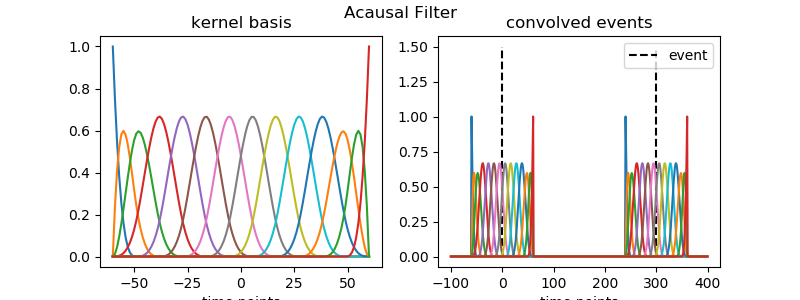

<IPython.core.display.Javascript object>


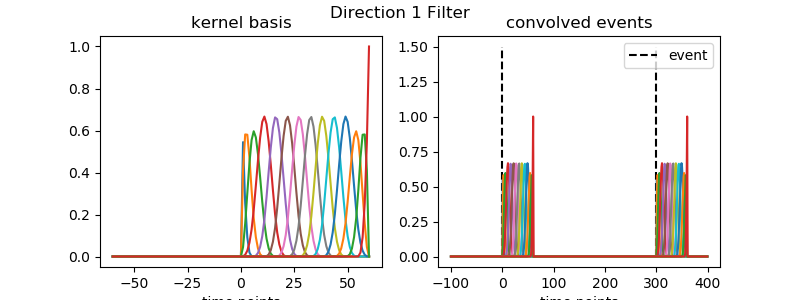

<IPython.core.display.Javascript object>


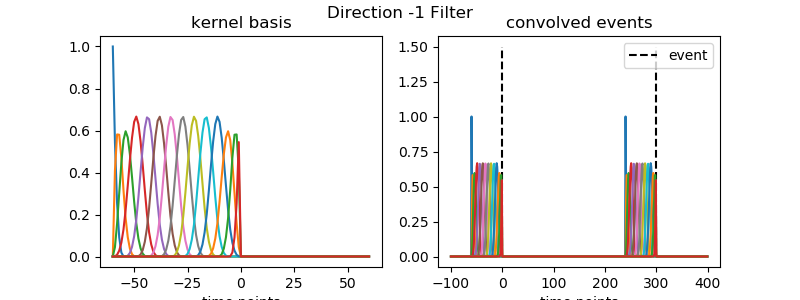

In [12]:

# Define a series of event marker
tot_tp = 10**3

# set some trial ids
trial_ids = np.zeros(tot_tp)
trial_ids[400:] = 1

# sample some event marker at random
event = np.zeros(tot_tp)
event[[100, 200, 600, 900]] = 1

# define the b-spline params
kernel_h_legnth = 121 # duration of the kernel h(t) in time points 
num_int_knots = 12 # number of internal knots used to represent h
order = 4
dict_kernel = {0:'Acausal',1:'Direction %d'%1, -1:'Direction %d'%(-1)}


for kernel_direction in [0,1,-1]:
    # define the "smooths_handler" container
    sm_handler = gdh.smooths_handler()
    
    # add the covariate & evaluate the convolution
    sm_handler.add_smooth('this_event', 
                          [event], 
                          is_temporal_kernel=True, 
                          ord=order, 
                          knots_num=num_int_knots,
                          trial_idx=trial_ids,
                          kernel_length=kernel_h_legnth,
                          kernel_direction=kernel_direction)

    # sm_handler['varname'] process and stores the B-spline for the variable
    # below we retrive the B-spline convolved with the "event" variable
    convolved_ev = sm_handler['this_event'].X.toarray()
    
    # retrive the B-spline used for the convolution
    basis = sm_handler['this_event'].basis_kernel.toarray()

    # plot the basis & the convolved events
    plt.figure(figsize=(8,3))
    plt.suptitle('%s Filter'%dict_kernel[kernel_direction])
    
    # basis for the kenel h
    plt.subplot(121)
    plt.title('kernel basis')
    tps = np.repeat(np.arange(kernel_h_legnth)-kernel_h_legnth//2, basis.shape[1]).reshape(basis.shape)
    plt.plot(tps, basis)
    plt.xlabel('time points')

    plt.subplot(122)
    plt.title('convolved events')

    # select a time point interval containing an event
    idx0, idx1 = np.where(event == 1)[0][2] - 100, np.where(event == 1)[0][2] + 400

    # extract the events convolved with each of the B-spline elements
    conv = convolved_ev[idx0:idx1,:]

    tps = np.arange(0,idx1-idx0) - 100
    tps = np.repeat(tps,conv.shape[1]).reshape(conv.shape)
    plt.plot(tps, conv)
    plt.vlines(tps[0,0] + np.where(event[idx0:idx1])[0],0,1.5,'k',ls='--',label='event')
    plt.xlabel('time points')
    plt.legend()


### 2.1.3 Spatial variable 1D and 2D

Example "spatial" variables.

src/PGAM/gam_data_handlers.py:33: RuntimeWarning: invalid value encountered in greater_equal
  in_x = (x >= knots[0]) & (x <= knots[-1]) & not_nan
src/PGAM/gam_data_handlers.py:33: RuntimeWarning: invalid value encountered in less_equal
  in_x = (x >= knots[0]) & (x <= knots[-1]) & not_nan


<IPython.core.display.Javascript object>


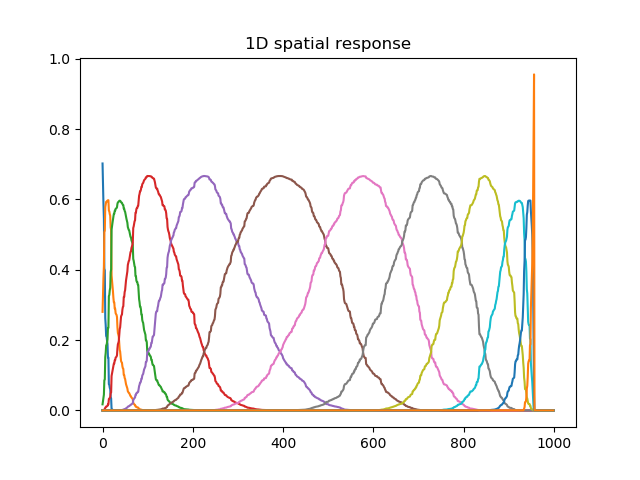

Size of X_1D (1000, 12)
Size of X_2D (1000, 144)


src/PGAM/gam_data_handlers.py:33: RuntimeWarning: invalid value encountered in greater_equal
  in_x = (x >= knots[0]) & (x <= knots[-1]) & not_nan
src/PGAM/gam_data_handlers.py:33: RuntimeWarning: invalid value encountered in less_equal
  in_x = (x >= knots[0]) & (x <= knots[-1]) & not_nan


In [13]:
# generate three covariate
x = np.random.normal(size=tot_tp)
y = np.random.normal(size=tot_tp)
z = np.random.normal(size=tot_tp)

# add the 1d spatial variable
int_knots = np.linspace(-2,2,10)
order = 4
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))

# remove out of range values
x[np.abs(x)>2] = np.nan
y[np.abs(y)>2] = np.nan
z[np.abs(z)>2] = np.nan

# add the variable
if 'spatial_1D' in sm_handler.smooths_var:
    sm_handler.smooths_var.remove('spatial_1D')
    sm_handler.smooths_dict.pop('spatial_1D')
    
sm_handler.add_smooth('spatial_1D', [x], 
                      knots=[knots], 
                      ord=order, 
                      is_temporal_kernel=False,
                      trial_idx=trial_ids, 
                      is_cyclic=[False])


# retrive the b-spline evaluated at x.
X_1D = sm_handler['spatial_1D'].X.toarray()


# sort for plotting
plt.figure()
plt.title('1D spatial response')
idx_srt = np.argsort(x)
X_srt = X_1D[idx_srt]
p = plt.plot(X_srt)

# add a 2D response with one cyclic variable and one acyclic
if 'spatial_2D' in sm_handler.smooths_var:
    sm_handler.smooths_var.remove('spatial_2D')
    sm_handler.smooths_dict.pop('spatial_2D')

sm_handler.add_smooth('spatial_2D', [y,z], knots=[knots, knots], ord=order, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False,True])
X_2D = sm_handler['spatial_2D'].X.toarray()


# the size of basis set grows as n^m where n is the basis in the 1D case, and m is the number of dimensions
print('Size of X_1D',X_1D.shape)
print('Size of X_2D',X_2D.shape)

## 2.2 Model fit <a name="model-fit">
Putting all the pieces together, here we will create a *smooths_handler* object containing the appropriate covariates, fit the model, evaluate the fit quality, and save the post-processed outputs in a standard numpy structured array or as a MATLAB structure.
    
The class **general_additive_model** is used for defining the GAM. It requires the following inputs:
    
* **sm_handler**: the smooths_handler object
* **var_list**: list of variable names
* **y**: the array with the spike counts (all trials must be stacked in a 1D array)
* **link**: statsmoldels.genmod.families.links.link class which describe the link function (the library allows to fit any exponential family observation noise)


You can fit the GAM with the method **general_additive_model.fit_full_and_reduced**, which fits a model with all the variables in **var_list**, then selects a minimal subset of variables that drive the neural activity by statistical testing, and re-fits the model with the significant variables only.
    
The inputs for **fit_full_and_reduced** requires are the following:

* **var_list**: list with the subset of variables to be used for model fitting 
* **th_pval**: float between 0 and 1,the significance level for task variable inclusion
* **max_iter**: int, max number of iteration of the optization routine
* **use_dgcv**: True for learning the smoothing constants via dgcv
* **trial_idx**: vector of length the number of samples containing the trial ids of each sample
* **filter_trials**: vector of boolean, of the same length of *trial_idx*, indicates which time points should be used for training the model

    
In the following subsection we will provide an example where spike counts are generated according to the PGAM assumptions, and estimate the response function within the GAM framework.



### 2.2.1 Generate synthetic data
Below we generate a syntetic dataset.

In [14]:

## inputs parameters
num_events = 6000
time_points = 3 * 10 ** 5  # 30 mins at 0.006 ms resolution
rate = 5. * 0.006  # Hz rate of the final kernel
variance = 5.  # spatial input and nuisance variance
int_knots_num = 20  # num of internal knots for the spline basis
order = 4  # spline order

## assume 200 trials
trial_ids = np.repeat(np.arange(200),time_points//200)

## create temporal input
idx = np.random.choice(np.arange(time_points), num_events, replace=False)
events = np.zeros(time_points)
events[idx] = 1

rv = sts.multivariate_normal(mean=[0, 0], cov= variance * np.eye(2))
samp = rv.rvs(time_points)
spatial_var = samp[:, 0]
nuisance_var = samp[:, 1]

# truncate X to avoid jumps in the resp function
sele_idx = np.abs(spatial_var) < 5
spatial_var = spatial_var[sele_idx]
nuisance_var = nuisance_var[sele_idx]
while spatial_var.shape[0] < time_points:
    tmpX = rv.rvs(10 ** 4)
    sele_idx = np.abs(tmpX[:, 0]) < 5
    tmpX = tmpX[sele_idx, :]

    spatial_var = np.hstack((spatial_var, tmpX[:, 0]))
    nuisance_var = np.hstack((nuisance_var, tmpX[:, 1]))
spatial_var = spatial_var[:time_points]
nuisance_var = nuisance_var[:time_points]

# create a resp function
knots = np.hstack(([-5]*3, np.linspace(-5,5,8),[5]*3))
beta = np.arange(10)
beta = beta / np.linalg.norm(beta)
beta = np.hstack((beta[5:], beta[:5][::-1]))
resp_func = lambda x : np.dot(gdh.splineDesign(knots, x, order, der=0),beta)

filter_used_conv = sts.gamma.pdf(np.linspace(0,20,100),a=2) - sts.gamma.pdf(np.linspace(0,20,100),a=5)
filter_used_conv = np.hstack((np.zeros(101),filter_used_conv))*2
# mean of the spike counts depending on spatial_var and events
log_mu0 = resp_func(spatial_var)
for tr in np.unique(trial_ids):
    log_mu0[trial_ids == tr] = log_mu0[trial_ids == tr] + np.convolve(events[trial_ids == tr], filter_used_conv, mode='same')

# adjust mean rate
const = np.log(np.mean(np.exp(log_mu0)) / rate)
log_mu0 = log_mu0 - const

# generate spikes
spk_counts = np.random.poisson(np.exp(log_mu0))

<IPython.core.display.Javascript object>


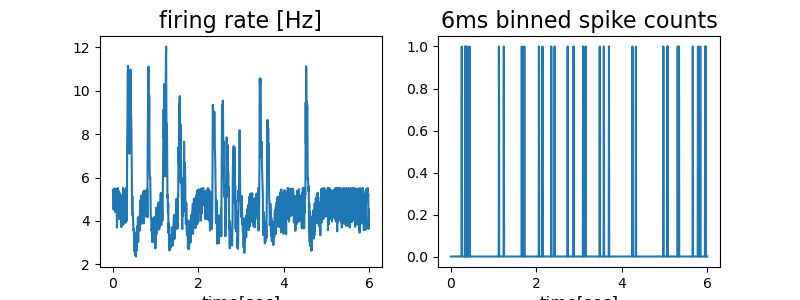

Text(0.5, 0, 'time[sec]')

In [14]:
# plot the firing rate and the spike counts generated
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(np.arange(1000) * 0.006, np.exp(log_mu0)[:1000]/0.006)
plt.title('firing rate [Hz]', fontsize=16)
plt.xlabel('time[sec]', fontsize=12)

plt.subplot(122)
plt.plot(np.arange(1000) * 0.006, spk_counts[:1000])
plt.title('6ms binned spike counts', fontsize=16)
plt.xlabel('time[sec]', fontsize=12)

### 2.2.2 Create the *smooths_handler* object and fit the model
Below we create the smooths_handler object and run a fit. We include a "nuisance" spatial variable, that is not driving the neuron, the fit will learn to discard the variable;

In [15]:
import statsmodels.api as sm

# Creating the class
sm_handler = smooths_handler()
# Creating the knots (notice the over-representation of edge knots)
knots = np.hstack(([-5]*3, np.linspace(-5,5,15),[5]*3))
# Using smooths_handler class to add variables 
sm_handler.add_smooth('spatial', [spatial_var], knots=[knots], ord=4, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2)

sm_handler.add_smooth('nuisance', [nuisance_var], knots=[knots], ord=4, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2)

sm_handler.add_smooth('temporal', [events], knots=None, ord=4, is_temporal_kernel=True,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2,
                     knots_num=10, kernel_length=500, kernel_direction=1)


# split trial in train and eval
train_trials = trial_ids % 10 != 0
eval_trials = ~train_trials


link = sm.genmod.families.links.log()
poissFam = sm.genmod.families.family.Poisson(link=link)

# create the pgam model
pgam = general_additive_model(sm_handler,
                              sm_handler.smooths_var, # list of covariate we want to include in the model
                              spk_counts, # vector of spike counts
                              poissFam # poisson family with exponential link from statsmodels.api
                             )

# with with all covariate, remove according to stat testing, and then refit
full, reduced = pgam.fit_full_and_reduced(sm_handler.smooths_var, 
                                          th_pval=0.001,# pval for significance of covariate icluseioon
                                          max_iter=10 ** 2, # max number of iteration
                                          use_dgcv=True, # learn the smoothing penalties by dgcv
                                          trial_num_vec=trial_ids,
                                          filter_trials=train_trials)

print('Minimal subset of variables driving the activity:')
print(reduced.var_list)

Minimal subset of variables driving the activity:
['spatial' 'temporal']


## 2.3 Post processing<a name="post-proc">
After a fit, it is possible to post-process the model fit output to obtain an easy to parse result in the form of a numpy.structarray. 

Each row will represent results for a specific input variable, additional information about the neuron (e.g. channel ID, electrode ID, or anything else) can be provided in the form of a dictionary, each dictionary value will be stored in the structured array with type "object".

The output structure can be saved either as a ".npy" via *numpy.save(\<filename\>)* or as a .mat (for MATLAB) via *scipy.io.savemat(\<filename*\>)*.

Below is an example of the post-processing applied to the fit just obtained.

hstack: 0.35060755199992855 sec
hstack: 0.1810291449999113 sec



Result structarray types

neuron_id: 	 <class 'numpy.str_'>
fr: 	 <class 'numpy.float64'>
full_pseudo_r2_train: 	 <class 'numpy.float64'>
full_pseudo_r2_eval: 	 <class 'numpy.float64'>
reduced_pseudo_r2_train: 	 <class 'numpy.float64'>
reduced_pseudo_r2_eval: 	 <class 'numpy.float64'>
variable: 	 <class 'numpy.str_'>
pval: 	 <class 'numpy.float64'>
reduced_pval: 	 <class 'numpy.float64'>
mutual_info: 	 <class 'numpy.float64'>
x_rate_Hz: 	 <class 'numpy.ndarray'>
model_rate_Hz: 	 <class 'numpy.ndarray'>
raw_rate_Hz: 	 <class 'numpy.ndarray'>
reduced_x_rate_Hz: 	 <class 'numpy.ndarray'>
reduced_model_rate_Hz: 	 <class 'numpy.ndarray'>
reduced_raw_rate_Hz: 	 <class 'numpy.ndarray'>
eval_x_rate_Hz: 	 <class 'numpy.ndarray'>
eval_model_rate_Hz: 	 <class 'numpy.ndarray'>
eval_raw_rate_Hz: 	 <class 'numpy.ndarray'>
eval_reduced_x_rate_Hz: 	 <class 'numpy.ndarray'>
eval_reduced_model_rate_Hz: 	 <class 'numpy.ndarray'>
eval_reduc

<IPython.core.display.Javascript object>


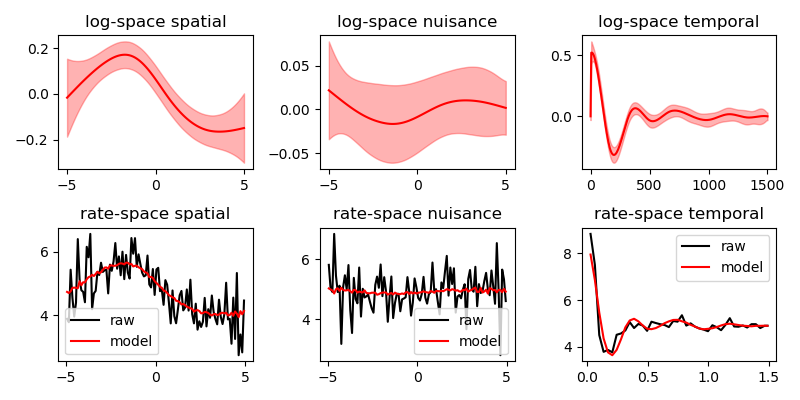

In [16]:
# string with the neuron identifier
neuron_id = 'neuron_000_session_1_monkey_001'
# dictionary containing some information about the neuron, keys must be strings and values can be anything
# since are stored with type object.
info_save = {'x':100,
             'y':801.2,
             'z':301,
             'brain_region': 'V1',
             'subject':'monkey_001'
            }

# assume that we used 90% of the trials for training, 10% for evaluation
res = postprocess_results(neuron_id, spk_counts, full, reduced, train_trials,
                        sm_handler, poissFam, trial_ids, var_zscore_par=None,info_save=info_save,bins=100)

# each row of res contains the info about a variable
# some info are shared for all the variables (p-rsquared for example is a goodness of fit measure for the model
# it is shared, not a property of the variable), while other, like the parameters of the b-splines, 
# are variable specific
print('\n\n')
print('Result structarray types\n========================\n')
for name in res.dtype.names:
    print('%s: \t %s'%(name, type(res[name][0])))


# plot tuning functions
plt.figure(figsize=(8,4))

for k in range(3):
    plt.subplot(2,3,k+1)
    plt.title('log-space %s'%res['variable'][k])
    x_kernel = res['x_kernel'][k]
    y_kernel = res['y_kernel'][k]
    ypCI_kernel = res['y_kernel_pCI'][k]
    ymCI_kernel = res['y_kernel_mCI'][k]
    
    plt.plot(x_kernel, y_kernel, color='r')
    plt.fill_between(x_kernel, ymCI_kernel, ypCI_kernel, color='r', alpha=0.3)
    
    
    
    x_firing = res['x_rate_Hz'][k]
    y_firing_model = res['model_rate_Hz'][k]
    y_firing_raw = res['raw_rate_Hz'][k]
    
    plt.subplot(2,3,k+4)
    plt.title('rate-space %s'%res['variable'][k])
    
    plt.plot(x_firing, y_firing_raw, color='k',label='raw')
    plt.plot(x_firing, y_firing_model, color='r',label='model')
    
    plt.legend()
    plt.tight_layout()
    
    
    

In [17]:
# saving the output for further analysis
#np.save('/notebooks/result_pgam.npy', res)
#savemat('/notebooks/result_pgam.mat', mdict = {'result_pgam':res})

# References <a name="refs"></a>
<a id="1">[1]</a> 
<a href="https://proceedings.neurips.cc/paper/2020/hash/94d2a3c6dd19337f2511cdf8b4bf907e-Abstract.html">
Balzani, Edoardo , et al., 
"Efficient estimation of neural tuning during naturalistic behavior."
Advances in Neural Information Processing Systems 33 (2020): 12604-12614.<a>